In [ ]:
!pip install kmodes

In [ ]:
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import plotnine
import matplotlib.pylab as plt
import time

from pathlib import Path
from sklearn.metrics import silhouette_score
from kmodes.kprototypes import KPrototypes
from plotnine import *

In [ ]:
sourcepath = 'https://raw.githubusercontent.com/FTPGitHub/TDG/main/datos'

In [ ]:
# Lee dataset estandarizado de transacciones
dfNoSupervisado1 = pd.read_csv("{}/transacciones.csv".format(sourcepath))

In [ ]:
dfNoSupervisado1.AISLE = dfNoSupervisado1.AISLE.astype(str)

In [ ]:
dfNoSupervisado1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16239 entries, 0 to 16238
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   AISLE     16239 non-null  object 
 1   IG        16239 non-null  object 
 2   HTS       16239 non-null  object 
 3   PLANNING  16239 non-null  object 
 4   ABC       16239 non-null  object 
 5   UOM       16239 non-null  object 
 6   CAT       16239 non-null  object 
 7   COSTX     16239 non-null  float64
 8   QTYVAR    16239 non-null  float64
dtypes: float64(2), object(7)
memory usage: 1.1+ MB


In [ ]:
dfNoSupervisado1.head()

AISLE    IG     HTS PLANNING ABC UOM    CAT     COSTX    QTYVAR
0    17  IG56  HTS119      1/1   B  PC  CAT17 -0.029976 -0.053250
1    17  IG56  HTS119      1/1   B  PC  CAT17  0.092472 -0.022999
2    17  IG56  HTS119      1/1   C  PC  CAT17  0.266130  0.004373
3    17  IG56  HTS119      1/1   B  PC  CAT17 -0.025112 -0.060323
4    15  IG56  HTS119      1/1   C  PC  CAT17 -0.077982 -0.062534

In [ ]:
# Posición de las variables categóricas
catColumnsPos = [dfNoSupervisado1.columns.get_loc(col) for col in list(dfNoSupervisado1.select_dtypes('object').columns)]
print('Categorical columns : {}'.format(list(dfNoSupervisado1.select_dtypes('object').columns)))
print('Categorical columns position : {}'.format(catColumnsPos))

Categorical columns : ['AISLE', 'IG', 'HTS', 'PLANNING', 'ABC', 'UOM', 'CAT']
Categorical columns position : [0, 1, 2, 3, 4, 5, 6]


In [ ]:
# Posición de las variables numéricas]
numColumnsPos = [dfNoSupervisado1.columns.get_loc(col) for col in list(dfNoSupervisado1.select_dtypes('float64').columns)]
print('Numerical columns : {}'.format(list(dfNoSupervisado1.select_dtypes('float64').columns)))
print('Numerical columns position : {}'.format(numColumnsPos))

Numerical columns : ['COSTX', 'QTYVAR']
Numerical columns position : [7, 8]


In [ ]:
import numba as nb

In [ ]:
dfNoSupervisado1.reset_index(drop=True)
N = dfNoSupervisado1.shape[0]

dataNum= dfNoSupervisado1.iloc[:,numColumnsPos]
dataNum=dataNum.to_numpy()
print('Datos numéricos',type(dataNum))

dataCat=dfNoSupervisado1.iloc[:,catColumnsPos]
dataCat=dataCat.to_numpy()
print('Datos categóricos',type(dataCat))

# gamma = 0.5 (constante)
catWeight=0.5

start_time = time.time()

Datos numéricos <class 'numpy.ndarray'>
Datos categóricos <class 'numpy.ndarray'>


In [ ]:
@nb.njit
def dist_num_njit(data):
    scores = np.zeros((len(data),len(data)), dtype=np.float64)
    valor = nb.float64(0)

    for i in range(len(data)):
        for j in range(i+1, len(data)):
            valor = nb.float64(np.sum((data[i] - data[j]) ** 2))
            scores[i][j] = valor
    return scores

In [ ]:
def dist_cat(data, catWeight):
    scores = np.zeros((len(data),len(data)), dtype=np.float64)
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            scores[i][j] = np.float64(np.sum(data[i]!=data[j])*catWeight)
    return scores

In [ ]:
@nb.njit
def traspose_njit (data):
    scores = data
    for i in range(len(data)):
        for j in range(1+i,len(data)):
            scores[j][i] = scores[i][j]
    return scores            

In [ ]:
def get_scores(data,catWeight):
    %time dist_num_np = dist_num_njit(dataNum[range(i)])
    %time dist_cat_np = dist_cat(dataCat[range(i)], catWeight)
    %time total = np.sum([dist_cat_np, dist_num_np], axis=0)
    %time total = traspose_njit(total)

In [ ]:
filename='NoCheck'
if not Path('{}/{}'.format(sourcepath,filename)).is_file():
    start_time = time.time()
    for i in [10, dataNum.shape[0]]:
        print('Número de filas a procesar: {}'.format(i))
        %time dist_num_np = dist_num_njit(dataNum[range(i)])
        %time dist_cat_np = dist_cat(dataCat[range(i)], catWeight)
        %time total = np.sum([dist_cat_np, dist_num_np], axis=0)
        %time total = traspose_njit(total)
        print()
#    %time np.savetxt('{}/{}'.format(sourcepath,filename),total, delimiter=',')  
    print('Tiempo total = {}'.format(time.time() - start_time))
else: 
    print('El archivo {} ya existe'.format(filename))

Número de filas a procesar: 10
CPU times: user 671 ms, sys: 23.5 ms, total: 694 ms
Wall time: 737 ms
CPU times: user 606 µs, sys: 0 ns, total: 606 µs
Wall time: 610 µs
CPU times: user 40 µs, sys: 7 µs, total: 47 µs
Wall time: 50.5 µs
CPU times: user 125 ms, sys: 3.01 ms, total: 128 ms
Wall time: 127 ms

Número de filas a procesar: 16239
CPU times: user 10.1 s, sys: 546 ms, total: 10.6 s
Wall time: 10.5 s
CPU times: user 23min 9s, sys: 3.04 s, total: 23min 12s
Wall time: 23min 13s
CPU times: user 865 ms, sys: 928 ms, total: 1.79 s
Wall time: 1.78 s
CPU times: user 488 ms, sys: 1.01 ms, total: 489 ms
Wall time: 485 ms

Tiempo total = 1407.342961549759


In [ ]:
if len(total)>0:
    scores = pd.DataFrame(total)
else: 
    %time scores = pd.read_csv('{}/{}'.format(sourcepath,filename),header=None)

In [ ]:
scores.head()

0         1         2      ...     16236     16237     16238
0  0.000000  0.015909  0.590999  ...  4.753847  3.558992  3.502744
1  0.015909  0.000000  0.530906  ...  4.488869  3.634796  3.519995
2  0.590999  0.530906  0.000000  ...  3.670329  3.291519  3.095380
3  0.000074  0.015219  0.589008  ...  4.745281  3.559681  3.502012
4  1.002391  1.030617  0.622889  ...  4.365574  3.038450  3.004875

[5 rows x 16239 columns]

In [ ]:
cost = []
silueta = []
start_time = time.time()

for k in (range(1,11)):
# try:
    kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', gamma = 0.5, random_state = 0)
    kprototype.fit_predict(dfNoSupervisado1, categorical = catColumnsPos)
    cost.append(kprototype.cost_)
    print('k: {}'.format(k))
    print("--- %s seconds ---" % (time.time() - start_time))
    if k != 1:
        silhouette_coeff = silhouette_score(scores, kprototype.labels_, metric='precomputed')
        silueta.append(silhouette_coeff)
        print("Coeficiente silueta --- %s seconds ---" % (time.time() - start_time))
        print(silhouette_coeff)
    # except:
    #     break

k: 1
--- 20.487010717391968 seconds ---
k: 2
--- 124.03669500350952 seconds ---
Coeficiente silueta --- 125.73675441741943 seconds ---
0.7368588147337156
k: 3
--- 240.59661388397217 seconds ---
Coeficiente silueta --- 242.2838044166565 seconds ---
0.7182825853232915
k: 4
--- 355.78829431533813 seconds ---
Coeficiente silueta --- 357.25487542152405 seconds ---
0.10914930712265486
k: 5
--- 484.63542890548706 seconds ---
Coeficiente silueta --- 486.1024286746979 seconds ---
0.1391253039621705
k: 6
--- 618.6451871395111 seconds ---
Coeficiente silueta --- 620.0591375827789 seconds ---
0.16195435391945107
k: 7
--- 793.7495946884155 seconds ---
Coeficiente silueta --- 795.1350929737091 seconds ---
0.14642970918022294
k: 8
--- 972.8448345661163 seconds ---
Coeficiente silueta --- 974.1871247291565 seconds ---
0.15780128213560415
k: 9
--- 1161.3708102703094 seconds ---
Coeficiente silueta --- 1162.691623210907 seconds ---
0.1427476758851263
k: 10
--- 1385.0605652332306 seconds ---
Coeficiente 

In [ ]:
silueta

[0.7368588147337156,
 0.7182825853232915,
 0.10914930712265486,
 0.1391253039621705,
 0.16195435391945107,
 0.14642970918022294,
 0.15780128213560415,
 0.1427476758851263,
 0.16567644534445009]

In [ ]:
df_cost = pd.DataFrame({'Cluster':range(1,11), 'Cost':cost})
df_silueta = pd.DataFrame({'Cluster':range(2,11), 'Coeficiente':silueta})
silueta

[0.7368588147337156,
 0.7182825853232915,
 0.10914930712265486,
 0.1391253039621705,
 0.16195435391945107,
 0.14642970918022294,
 0.15780128213560415,
 0.1427476758851263,
 0.16567644534445009]

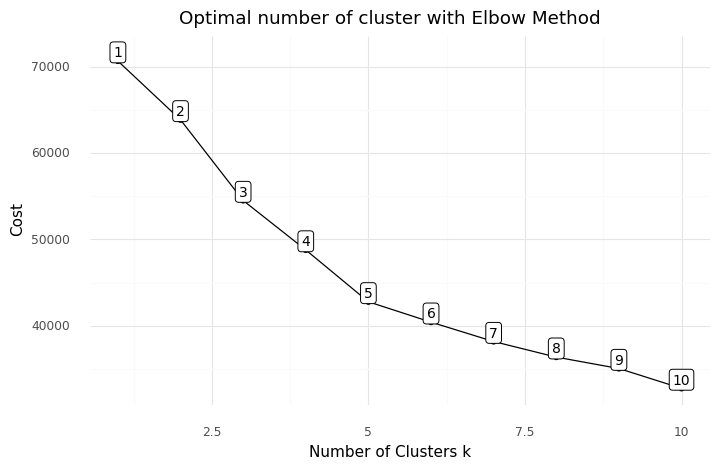

<ggplot: (8767344983637)>

In [ ]:
# Codo
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_cost)+
geom_line(aes(x = 'Cluster',
y = 'Cost'))+
geom_point(aes(x = 'Cluster',
y = 'Cost'))+
geom_label(aes(x = 'Cluster',
y = 'Cost',
label = 'Cluster'),
size = 10,
nudge_y = 1000) +
labs(title = 'Optimal number of cluster with Elbow Method')+
xlab('Number of Clusters k')+
ylab('Cost')+
theme_minimal()
)

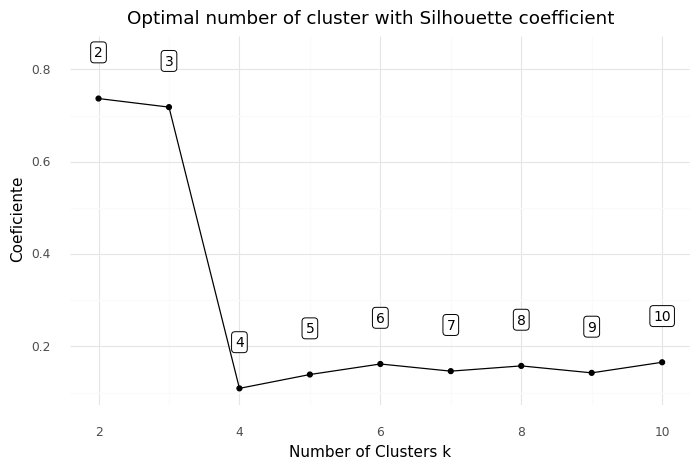

<ggplot: (8767344949725)>

In [ ]:
# Coeficiente silueta
plotnine.options.figure_size = (8, 4.8)
(
ggplot(data = df_silueta)+
geom_line(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_point(aes(x = 'Cluster',
y = 'Coeficiente'))+
geom_label(aes(x = 'Cluster',
y = 'Coeficiente',
label = 'Cluster'),
size = 10,
nudge_y = 0.1) +
labs(title = 'Optimal number of cluster with Silhouette coefficient')+
xlab('Number of Clusters k')+
ylab('Coeficiente')+
theme_minimal()
)

In [ ]:
# Fit the cluster 
k = 2
gamma = 0.5
import time
start_time = time.time()
kprototype = KPrototypes(n_jobs = -1, n_clusters = k, init = 'Huang', gamma = gamma, random_state = 0)
kprototype.fit_predict(dfNoSupervisado1, categorical = catColumnsPos)
print("--- %s seconds ---" % (time.time() - start_time))

--- 103.68883109092712 seconds ---


In [ ]:
dfNoSupervisado1['Cluster'] = kprototype.labels_

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


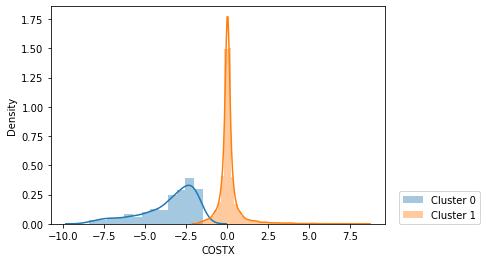

In [ ]:
for i in range(k):
  sns.distplot(dfNoSupervisado1.loc[dfNoSupervisado1['Cluster']==i,'COSTX'], label= 'Cluster {}'.format(i));
  plt.legend(loc=(1.04,0))
plt.show();

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


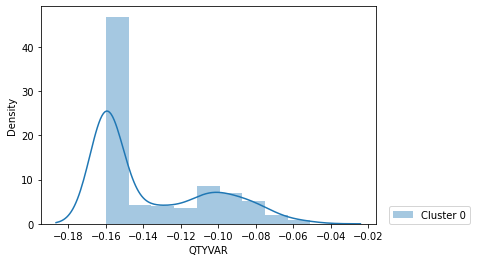

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


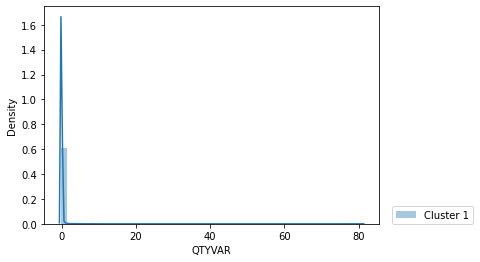

In [ ]:
for i in range(k):
    sns.distplot(dfNoSupervisado1.loc[dfNoSupervisado1['Cluster']==i,'QTYVAR'], label= 'Cluster {}'.format(i));
    plt.legend(loc=(1.04,0))
    plt.show()